In [1]:
import pandas as pd
import os
import glob
import numpy as np
import time
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

def get_path(country, week):
    base = f'../../data/03-experiment/{country}/'
    path_tw = base + f'treatment/followers/00-raw/tweets/{week}/'
    rand = f'../../data/02-randomize/{country}/04-stratification/integrate/followers_randomized.parquet'
    baseline = base + 'baseline/00-raw/followers/tweets/'
    agg = base + f'treatment/followers/01-preprocess/'
    agg_base = base + 'baseline/01-preprocess/followers/'
    return path_tw, base, rand, baseline, agg, agg_base

def summ_followers2(df):
    metrics = [col for col in df.columns if 'total_' in col]
    cols = metrics + ['verifiability', 'true', 'false']

    df_agg = df[['handle', 'author_id'] + 
        cols].groupby(['handle', 'author_id']).sum().reset_index()

    df_count = df[['handle', 'author_id']].groupby(['author_id']).count()
    df_count.rename({'handle': 'n_posts'}, axis=1, inplace=True)

    df_agg = df_agg.merge(df_count, on=['author_id'], how='left')

    return df_agg

In [2]:
from scipy.stats.mstats import winsorize

In [3]:
country = 'KE'
path_tw, base, rand, baseline, agg, agg_base = get_path(country, 'march')

if country == 'KE':
    n_arch = 84
else:
    n_arch = 74
df_final = pd.DataFrame()

for i in tqdm(range(0, n_arch)): #SA
    df = pd.read_parquet(f'{agg_base}predicted/baseline_{i}.parquet.gzip')
    df_final = pd.concat([df_final, df])

  0%|          | 0/84 [00:00<?, ?it/s]100%|██████████| 84/84 [03:02<00:00,  2.18s/it]


In [4]:
df_final['true'] = np.where(df_final['verifiability'] == 0, np.nan, df_final['true'])
df_final['false'] = np.where(df_final['true'] == 1, 0, 1)
df_final['false'] = np.where(df_final['true'].isnull(), np.nan, df_final['false'])

df_final = df_final.reset_index(drop = True)

df_RT = df_final[(df_final['text'].str.contains('RT @', case=True, regex=False)) & 
                 (df_final['total_comments'] == 0)]
df_RT = df_RT.reset_index(drop=True)

df_no_rt = df_final[(~df_final['text'].str.contains('RT @', 
                    case=True, regex=False)) | 
                    (df_final['total_comments'] > 0)].reset_index(drop=True)

df_final = pd.DataFrame()

In [5]:
df_rt_agg = summ_followers2(df_RT).reset_index(drop=True)
df_no_rt_agg = summ_followers2(df_no_rt).reset_index(drop=True)

df_RT = pd.DataFrame()
df_no_rt = pd.DataFrame()

In [6]:
df_rt_agg.rename(columns={'handle':'username',
                          'author_id':'follower_id'}, inplace=True)
df_no_rt_agg.rename(columns={'handle':'username',
                          'author_id':'follower_id'}, inplace=True)

### Verifiable False RTS and Posts

In [7]:
df_rt_agg1 = df_rt_agg[df_rt_agg['verifiability']>0]
df_no_rt_agg1 = df_no_rt_agg[df_no_rt_agg['verifiability']>0]

df_rt_agg1['false_w'] = winsorize(df_rt_agg1['false'], limits=[0, 0.05])
df_no_rt_agg1['false_w'] = winsorize(df_no_rt_agg1['false'], limits=[0, 0.05])

C:\Users\Dell\AppData\Local\Temp\ipykernel_14456\1366514958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rt_agg1['false_w'] = winsorize(df_rt_agg1['false'], limits=[0, 0.05])
C:\Users\Dell\AppData\Local\Temp\ipykernel_14456\1366514958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_rt_agg1['false_w'] = winsorize(df_no_rt_agg1['false'], limits=[0, 0.05])


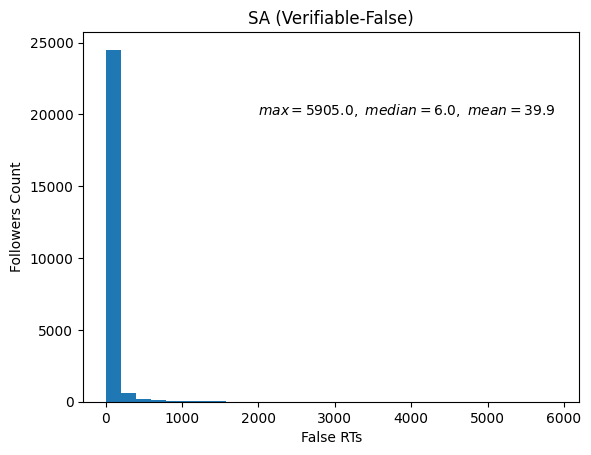

In [12]:
mu, max_n, mean = df_rt_agg1['false'].median(), df_rt_agg1['false'].max(), round(df_rt_agg1['false'].mean(), 3)
plt.hist(df_rt_agg1['false'], bins = 30)

if country == 'KE':
    n_min, n_max = 5000, 40000
else: 
    n_min, n_max = 2000, 20000

plt.xlabel('False RTs')
plt.ylabel('Followers Count')
plt.title(f'{country} (Verifiable-False)')
plt.text(n_min, n_max, f'$max={max_n},\ median={mu},\ mean={mean}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/{country}_ver_false_rts.png')
#plt.ylim(0, 1000)
plt.show()

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


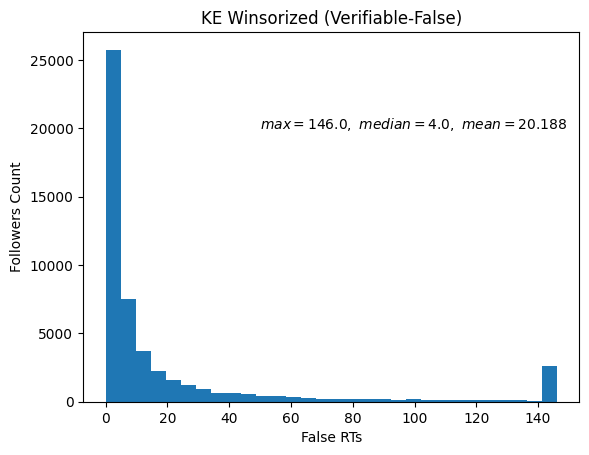

In [9]:
mu, max_n, mean = df_rt_agg1['false_w'].median(), df_rt_agg1['false_w'].max(), round(df_rt_agg1['false_w'].mean(), 3)
plt.hist(df_rt_agg1['false_w'], bins = 30)

if country == 'KE':
    n_min, n_max = 50, 20000
else: 
    n_min, n_max = 50, 10000

plt.xlabel('False RTs')
plt.ylabel('Followers Count')
plt.title(f'{country} Winsorized (Verifiable-False)')
plt.text(n_min, n_max, f'$max={max_n},\ median={mu},\ mean={mean}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/{country}_ver_false_rts_w.png')
#plt.ylim(0, 1000)
plt.show()

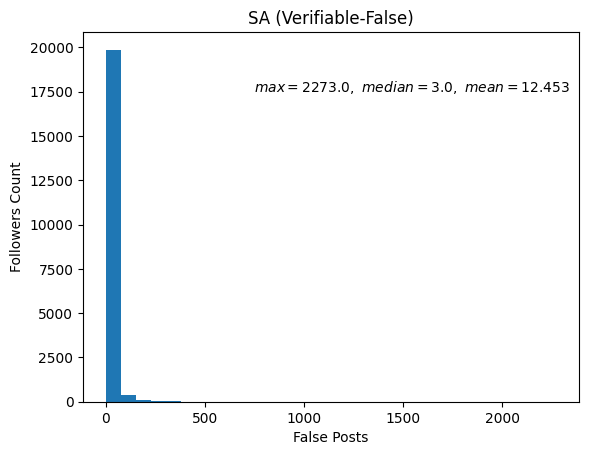

In [11]:
mu, max_n, mean = (df_no_rt_agg1['false'].median(), df_no_rt_agg1['false'].max(), 
                   round(df_no_rt_agg1['false'].mean(), 3))
plt.hist(df_no_rt_agg1['false'], bins = 30)

if country == 'KE':
    n_min, n_max = 2700, 30000
else: 
    n_min, n_max = 750, 17500

plt.xlabel('False Posts')
plt.ylabel('Followers Count')
plt.title(f'{country} (Verifiable-False)')
plt.text(n_min, n_max, f'$max={max_n},\ median={mu},\ mean={mean}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/{country}_ver_false.png')
#plt.ylim(0, 1000)
plt.show()

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


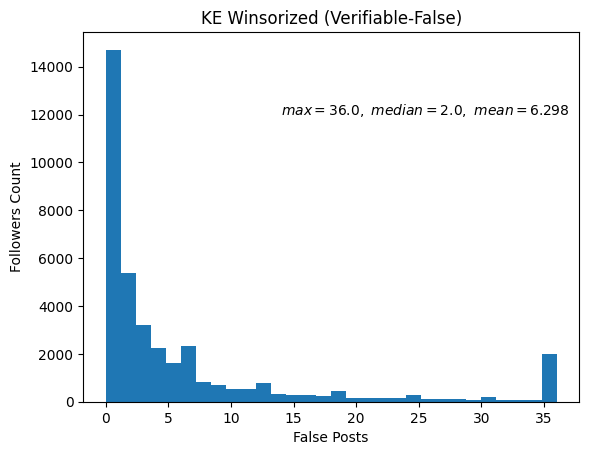

In [13]:
mu, max_n, mean = (df_no_rt_agg1['false_w'].median(), df_no_rt_agg1['false_w'].max(), 
                   round(df_no_rt_agg1['false_w'].mean(), 3))
plt.hist(df_no_rt_agg1['false_w'], bins = 30)

if country == 'KE':
    n_min, n_max = 14, 12000
else: 
    n_min, n_max = 20, 5000

plt.xlabel('False Posts')
plt.ylabel('Followers Count')
plt.title(f'{country} Winsorized (Verifiable-False)')
plt.text(n_min, n_max, f'$max={max_n},\ median={mu},\ mean={mean}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/{country}_ver_false_w.png')
#plt.ylim(0, 1000)
plt.show()

In [14]:
base1 = pd.read_parquet(f'../../data/04-analysis/{country}/baseline_rt.parquet')
base1.rename(columns = {'shares_base': 'total_shares_base', 
                       'reactions_base':'total_reactions_base',
                       'comments_base':'total_comments_base'}, inplace = True)

In [15]:
base2 = base1.merge(df_rt_agg[['follower_id', 'username', 'false']], 
                    on=['follower_id', 'username'], how='left')

base3 = base1.merge(df_no_rt_agg[['follower_id', 'username', 'false']], 
                    on=['follower_id', 'username'], how='left')

base2['false'] = np.where(base2['false'].isnull(), 0, base2['false'])
base3['false'] = np.where(base3['false'].isnull(), 0, base3['false'])

In [16]:
base2['false_w'] = winsorize(base2['false'], limits=[0, 0.05])
base3['false_w'] = winsorize(base3['false'], limits=[0, 0.05])

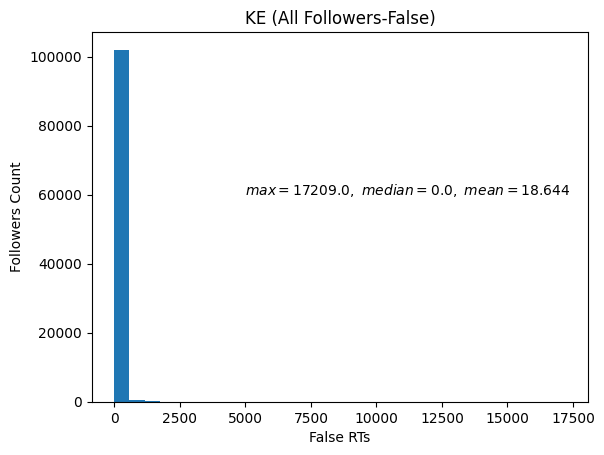

In [17]:
mu, max_n, mean = base2['false'].median(), base2['false'].max(), round(base2['false'].mean(), 3)
plt.hist(base2['false'], bins = 30)

if country == 'KE':
    n_min, n_max = 5000, 60000
else: 
    n_min, n_max = 2000, 25000

plt.xlabel('False RTs')
plt.ylabel('Followers Count')
plt.title(f'{country} (All Followers-False)')
plt.text(n_min, n_max, f'$max={max_n},\ median={mu},\ mean={mean}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/{country}_false_rts.png')
#plt.ylim(0, 1000)
plt.show()

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


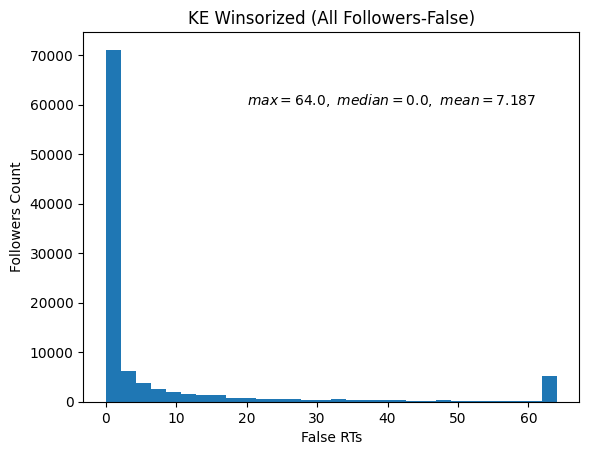

In [21]:
mu, max_n, mean = base2['false_w'].median(), base2['false_w'].max(), round(base2['false_w'].mean(), 3)
plt.hist(base2['false_w'], bins = 30)

if country == 'KE':
    n_min, n_max = 20, 60000
else: 
    n_min, n_max = 30, 25000

plt.xlabel('False RTs')
plt.ylabel('Followers Count')
plt.title(f'{country} Winsorized (All Followers-False)')
plt.text(n_min, n_max, f'$max={max_n},\ median={mu},\ mean={mean}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/{country}_false_rts_w.png')
#plt.ylim(0, 1000)
plt.show()

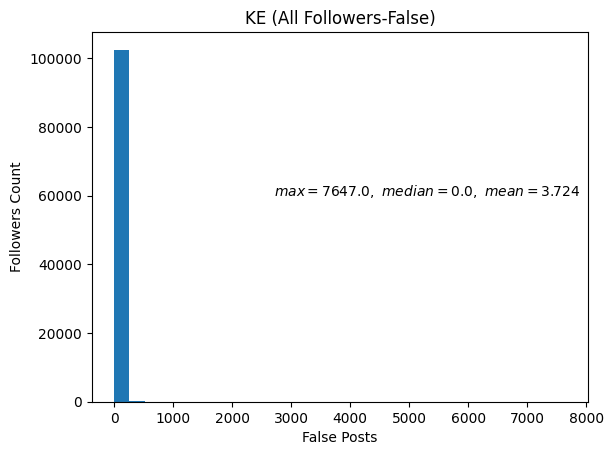

In [22]:
mu, max_n, mean = (base3['false'].median(), base3['false'].max(), 
                   round(base3['false'].mean(), 3))
plt.hist(base3['false'], bins = 30)

if country == 'KE':
    n_min, n_max = 2700, 60000
else: 
    n_min, n_max = 750, 30000

plt.xlabel('False Posts')
plt.ylabel('Followers Count')
plt.title(f'{country} (All Followers-False)')
plt.text(n_min, n_max, f'$max={max_n},\ median={mu},\ mean={mean}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/{country}_false.png')
#plt.ylim(0, 1000)
plt.show()

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


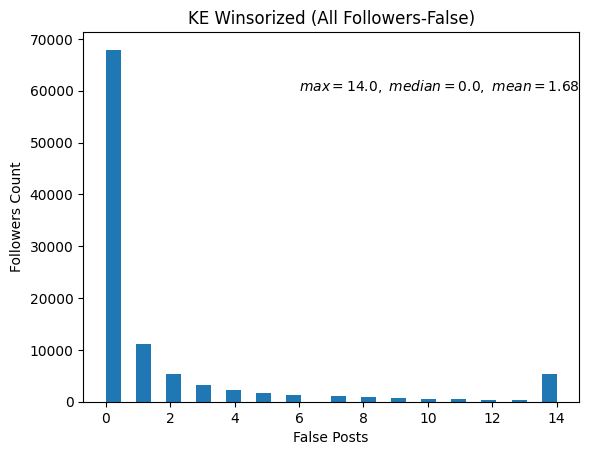

In [24]:
mu, max_n, mean = (base3['false_w'].median(), base3['false_w'].max(), 
                   round(base3['false_w'].mean(), 3))
plt.hist(base3['false_w'], bins = 30)

if country == 'KE':
    n_min, n_max = 6, 60000
else: 
    n_min, n_max = 10, 23000

plt.xlabel('False Posts')
plt.ylabel('Followers Count')
plt.title(f'{country} Winsorized (All Followers-False)')
plt.text(n_min, n_max, f'$max={max_n},\ median={mu},\ mean={mean}$')
#plt.xticks(np.arange(1, max_n+1, 1.0))
plt.savefig(f'../../results/00-summary_stats/{country}_false_w.png')
#plt.ylim(0, 1000)
plt.show()